# Ignition Example

This example uses `ctwrap` for ideal gas constant pressure reactor simulations (i.e. ignition) defined by the simulation module `ignition` (`ctwrap.modules.ignition`).

## 1. Function/Class Definitions

In [1]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

col = mpl.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
import ctwrap as cw
cw.__version__

'0.1.0'

## 2. Simulations

### 2.1 Create Simulation object

Uses a module in the `modules` folder. Modules do not have to depend on `ctwrap`.

In [4]:
sim = cw.Simulation.from_module(cw.modules.ignition)
sim

In [5]:
%%time
sim.run()

CPU times: user 498 ms, sys: 9.18 ms, total: 507 ms
Wall time: 515 ms


### 2.2 Create Simulation Handler

Parameters are specified via YAML file

In [6]:
# create variation object
fname = 'ignition.yaml'
sh = cw.SimulationHandler.from_yaml(fname, verbosity=1)
sh

Simulations for entry `initial.phi` with values: [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]


### 2.3 Run parallel simulation

In [7]:
%%time
sh.run_parallel(sim)

 * running simulation using 4 cores
 * processing `initial.phi_0.4` (Process-1)
 * processing `initial.phi_1.8` (Process-2)
 * processing `initial.phi_1.0` (Process-3)
 * processing `initial.phi_1.6` (Process-4)
 * processing `initial.phi_0.6` (Process-2)
 * processing `initial.phi_1.4` (Process-1)
 * processing `initial.phi_0.8` (Process-4)
 * processing `initial.phi_1.2` (Process-3)
CPU times: user 14.7 ms, sys: 17.1 ms, total: 31.8 ms
Wall time: 1.3 s


True

## 3. Create graphical output

### 3.1 Load data from file

In [8]:
# load data from output file
data = cw.fileio.from_hdf(sh.output_name)
data.keys()

dict_keys(['initial.phi_0.4', 'initial.phi_1.8', 'variation', 'initial.phi_1.0', 'initial.phi_1.6', 'initial.phi_0.6', 'defaults', 'initial.phi_1.4', 'initial.phi_0.8', 'initial.phi_1.2'])

In [9]:
# eliminate entries containing documentation
config = data.pop('defaults')
variation = data.pop('variation')
variation

{'entry': 'initial.phi',
 'tasks': ['initial.phi_0.4',
  'initial.phi_1.8',
  'initial.phi_1.0',
  'initial.phi_1.6',
  'initial.phi_0.6',
  'initial.phi_1.4',
  'initial.phi_0.8',
  'initial.phi_1.2'],
 'values': [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]}

### 3.2 Plot

Display time histories for gas temperature.

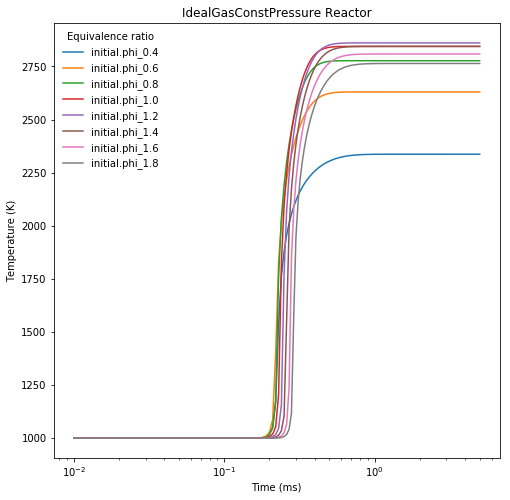

In [10]:
# create figure and adjust size
fig, ax = plt.subplots(1) 
fig.set_size_inches(8.,8.)

keys = list(data.keys())
keys.sort()

# plot results
for f, key in enumerate(keys):
    df = data[key]
    ax.semilogx(1000*df['t (s)'],df['T (K)'],color=col[f],label=key) 

# add title/axis labels
ax.set_title(r'IdealGasConstPressure Reactor')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Temperature (K)')

# add legend
leg = ax.legend(loc='upper left',#prop={'size':11},
                title='Equivalence ratio') # % mech)
leg.draw_frame(False) 

# show and save
plt.show()